In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#imports
import os
import glob
import random
from scipy.io import loadmat
import numpy as np
import cv2

import keras
from keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import mean_absolute_error
from keras.models import Sequential,load_model,Model
from keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf


Using TensorFlow backend.


In [3]:
#data paths

driveroot="/content/gdrive/My Drive"

rgbdir="/content/gdrive/My Drive/NTIRE2020_Clean"
hsdir="/content/gdrive/My Drive/NTIRE2020"

hpath=hsdir+'/ARAD_HS_*.mat'
rpath_clean=rgbdir+'/ARAD_HS_*_clean.png'
# print(rgbdir,hsdir,hpath,rpath_clean)

num_samples=230#number of files to load

image_size=128

hlist=glob.glob(hpath)[0:num_samples]
rgblist=glob.glob(rpath_clean)[0:num_samples]
print("number of hyperspectral imgs:",len(hlist))
print("number of rgb images:",len(rgblist))

number of hyperspectral imgs: 230
number of rgb images: 230


In [0]:
#validation sets
Y_val=np.load(driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/validation sets/ntire2020_hs_validationset_10.npy")
X_val=np.load(driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/validation sets/ntire2020_rgbclean_validationset_10.npy")
# Y_val=np.load(driveroot+"/ntire2020_hs_validationset_10.npy")
# X_val=np.load(driveroot+"/ntire2020_rgbclean_validationset_10.npy")

In [0]:
from skimage import img_as_ubyte
def normalize_data(data):
	# print("Normalizing Data ...........................")
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	temp = img_as_ubyte(data)
	# print(temp.shape, temp.dtype, "min:",temp.min(), "max:",temp.max())
	data = temp/temp.max()
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	return data	

def resize_npFile(data, image_size, file_save_path=None, save=False):	
#   print("Resizing the input data .................",data.shape)
  resize_np = np.zeros((data.shape[0],image_size, image_size, data.shape[3]))

  for j in range(data.shape[0]):
    for i in range(data.shape[3]):			
      # cv2.imwrite('org.png',img_as_ubyte(data[j][:,:,i]))
      temp = cv2.resize(data[j][:,:,i],(image_size, image_size), interpolation=cv2.INTER_AREA)	
      resize_np[j][:,:,i] = temp
      # print(data[j].shape, data[j][:,:,i].shape, temp.shape, resize_np[j].shape)			
  if save == True:
    np.save(file_save_path, resize_np)
    print('Successfully Saved .....', file_save_path, resize_np.shape)	
  return resize_np

In [7]:
#normalize
X_val=normalize_data(X_val)
Y_val=normalize_data(Y_val)

#resize
X_val=resize_npFile(X_val, image_size)
Y_val=resize_npFile(Y_val, image_size)
X_val.shape

(10, 128, 128, 3)

In [8]:
print("Validation set:",X_val.shape, Y_val.shape)

Validation set: (10, 128, 128, 3) (10, 128, 128, 31)


In [0]:
#model params
epochs=10
batch_size=8
lr=0.0001

initial_epoch=0

model_save_dir=driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/models"
model_name="cnn_normalised_10 autoencoder"
version=3

In [10]:
def load_batch_hyper(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        x=loadmat(filelist[i])
        matimg=x['cube']
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData

y=load_batch_hyper(hlist[5:10])
y.shape

(5, 482, 512, 31)

In [11]:
def load_batch_rgb(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        matimg = cv2.imread(filelist[i])
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData
x=load_batch_rgb(rgblist[5:10])
x.shape

(5, 482, 512, 3)

In [0]:
def imageLoader(files_x,files_y, batch_size):
    L = len(files_x)
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_batch_rgb(files_x[batch_start:limit])
            Y = load_batch_hyper(files_y[batch_start:limit])

            #normalize
            X=normalize_data(X)
            Y=normalize_data(Y)

            #resize
            X=resize_npFile(X, image_size)
            Y=resize_npFile(Y, image_size)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [0]:
def old_rgb2hs(image_size):
	model = Sequential()
	model.add(Convolution2D(32, kernel_size=(3, 3),
	                        input_shape=(image_size,image_size,3), padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	# model.add(Dropout(0.25))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	# model.add(Dropout(0.25))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))

	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))

	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(31,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))

	return model

In [0]:
model=old_rgb2hs(image_size)

In [18]:
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr), metrics=['mae','mse'])
checkpoint = keras.callbacks.ModelCheckpoint(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5',monitor='loss',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=50)
csv_logger = keras.callbacks.CSVLogger(model_save_dir + "/tr_-v"+str(version)+".csv", separator=',', append=True)

history=model.fit_generator(imageLoader(rgblist,hlist,batch_size), validation_data=(X_val, Y_val), steps_per_epoch=math.ceil(num_samples/batch_size), epochs=epochs,verbose=1,callbacks=[checkpoint, csv_logger], shuffle=True)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, initial_epoch=initial_epoch,
 					# validation_split=0.2,callbacks=[checkpoint, csv_logger], shuffle=False)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, 
                            # validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/10
29/29 [==============================] - 335s 12s/step - loss: 0.1189 - mae: 0.1195 - mse: 0.0367 - val_loss: 0.1448 - val_mae: 0.1448 - val_mse: 0.0419
Epoch 2/10
29/29 [==============================] - 360s 12s/step - loss: 0.0747 - mae: 0.0751 - mse: 0.0167 - val_loss: 0.0856 - val_mae: 0.0856 - val_mse: 0.0192
Epoch 3/10
29/29 [==============================] - 362s 12s/step - loss: 0.0572 - mae: 0.0574 - mse: 0.0107 - val_loss: 0.0753 - val_mae: 0.0753 - val_mse: 0.0145
Epoch 4/10
29/29 [==============================] - 358s 12s/step - loss: 0.0536 - mae: 0.0538 - mse: 0.0098 - val_loss: 0.0653 - val_mae: 0.0653 - val_mse: 0.0106
Epoch 5/10
29/29 [==============================] - 366s 13s/step - loss: 0.0486 - mae: 0.0487 - mse: 0.0080 - val_loss: 0.0612 - val_mae: 0.0612 - val_mse: 0.0097
Epoch 6/10
29/29 [==============================] - 357s 12s/step - loss: 0.0467 - mae: 0.0469 - mse: 0.0075 - val_loss: 0.0594 - val_mae: 0.0594 - val_mse: 0.0094
Epoch 7/10
29/29

In [19]:
history.history

{'loss': [0.11947921517750491,
  0.07505131198660187,
  0.057392969128230345,
  0.05382043766262739,
  0.04874846039582854,
  0.04687044408334338,
  0.04547611481469611,
  0.044576562357985454,
  0.043487786469252214,
  0.04234345989382785],
 'mae': [0.11947921,
  0.0750513,
  0.057392966,
  0.053820435,
  0.048748456,
  0.046870444,
  0.045476116,
  0.044576567,
  0.043487784,
  0.04234346],
 'mse': [0.036678106,
  0.016737984,
  0.0106885005,
  0.009755241,
  0.007989247,
  0.0075243074,
  0.0071965377,
  0.006983065,
  0.0067109056,
  0.006461275],
 'val_loss': [0.14475369751453399,
  0.08564630895853043,
  0.07531808614730835,
  0.06533677875995636,
  0.06119062751531601,
  0.05936574190855026,
  0.05815225318074226,
  0.05724166259169579,
  0.056320824474096295,
  0.056371137499809265],
 'val_mae': [0.14475369453430176,
  0.08564630895853043,
  0.07531808316707611,
  0.06533677875995636,
  0.06119062751531601,
  0.059365738183259964,
  0.058152250945568085,
  0.057241667062044144,

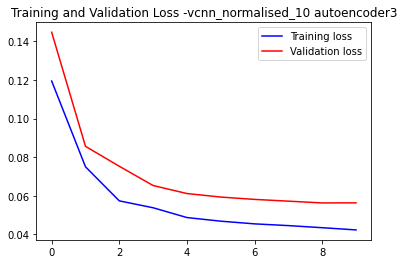

In [21]:
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss -v'+str(model_name)+str(version))
plt.legend()
plt.savefig(os.path.join(model_save_dir, str(model_name)+'_train_loss_'+str(version)+'_'+str(epochs)+'.png')) 
#plt.show()

In [20]:
model_json = model.to_json()
with open(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.json', "w+") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5')
print("Saved model to disk")

Saved model to disk


In [22]:
sample_x,sample_y=X_val[0],Y_val[0]
y_pred=model.predict(np.expand_dims(sample_x,axis=0))
y_pred.shape

(1, 128, 128, 31)

In [0]:
sample_y.shape

(128, 128, 31)

In [25]:
rmaee=abs(sample_y-y_pred[0])/sample_y
rmaee.shape

(128, 128, 31)

In [26]:
rmaee

array([[[1.        , 0.76484281, 0.90219638, ..., 0.30811042,
         0.22530907, 0.07743763],
        [1.        , 0.58951073, 0.74792077, ..., 0.0491001 ,
         0.05523337, 0.39628275],
        [1.        , 0.51330387, 0.57808119, ..., 0.12988791,
         0.33162286, 0.44055508],
        ...,
        [1.        , 0.54383229, 0.59759188, ..., 0.15391189,
         0.51328072, 0.24543441],
        [1.        , 0.68727979, 0.59505908, ..., 0.00382526,
         0.07163737, 0.28389431],
        [1.        , 0.86319857, 0.70441765, ..., 0.40949655,
         0.50432999, 0.60692833]],

       [[0.83320619, 0.64277161, 0.80951564, ..., 0.1436987 ,
         0.19053667, 0.11507446],
        [0.71233645, 0.51663949, 0.62412295, ..., 0.27689254,
         0.362215  , 0.63103777],
        [0.6610918 , 0.48415897, 0.46001977, ..., 0.47504558,
         0.5480226 , 0.76378123],
        ...,
        [0.65956548, 0.52734248, 0.48553795, ..., 0.36854191,
         0.51370504, 1.01718911],
        [0.7

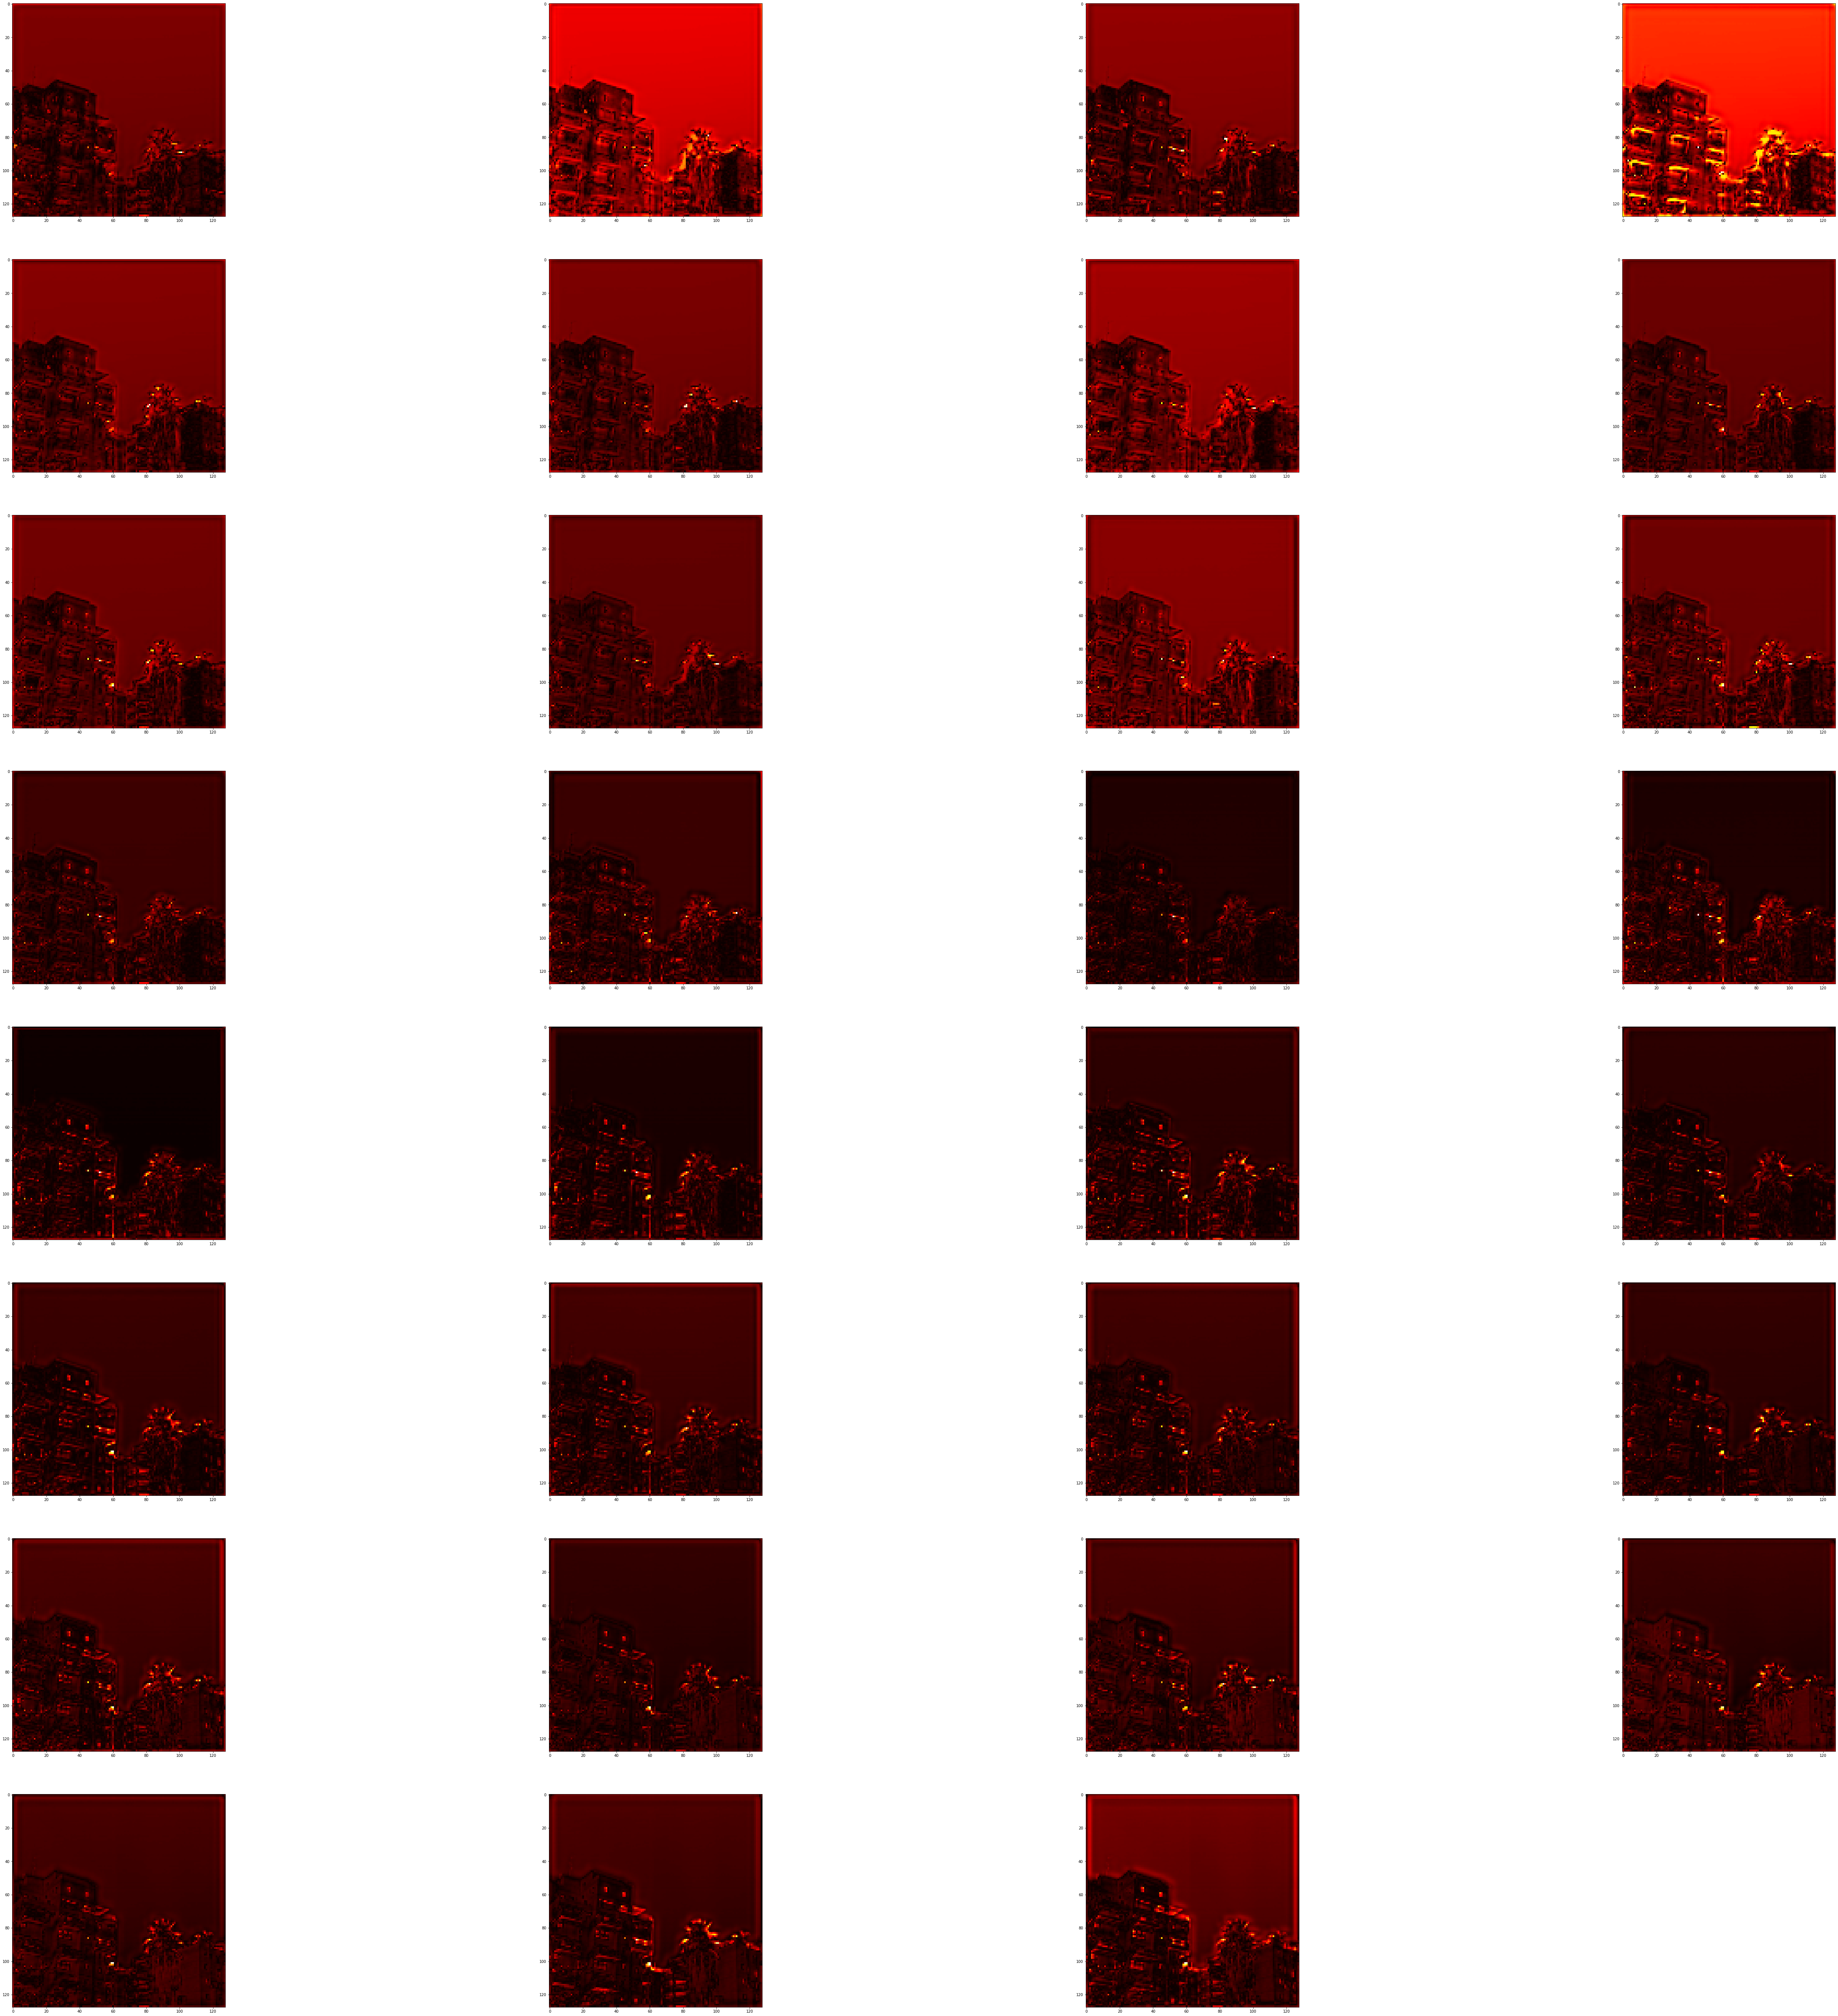

In [27]:
f=plt.figure(figsize=(100, 100))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap=plt.get_cmap('hot'), interpolation='nearest')
# plt.show()

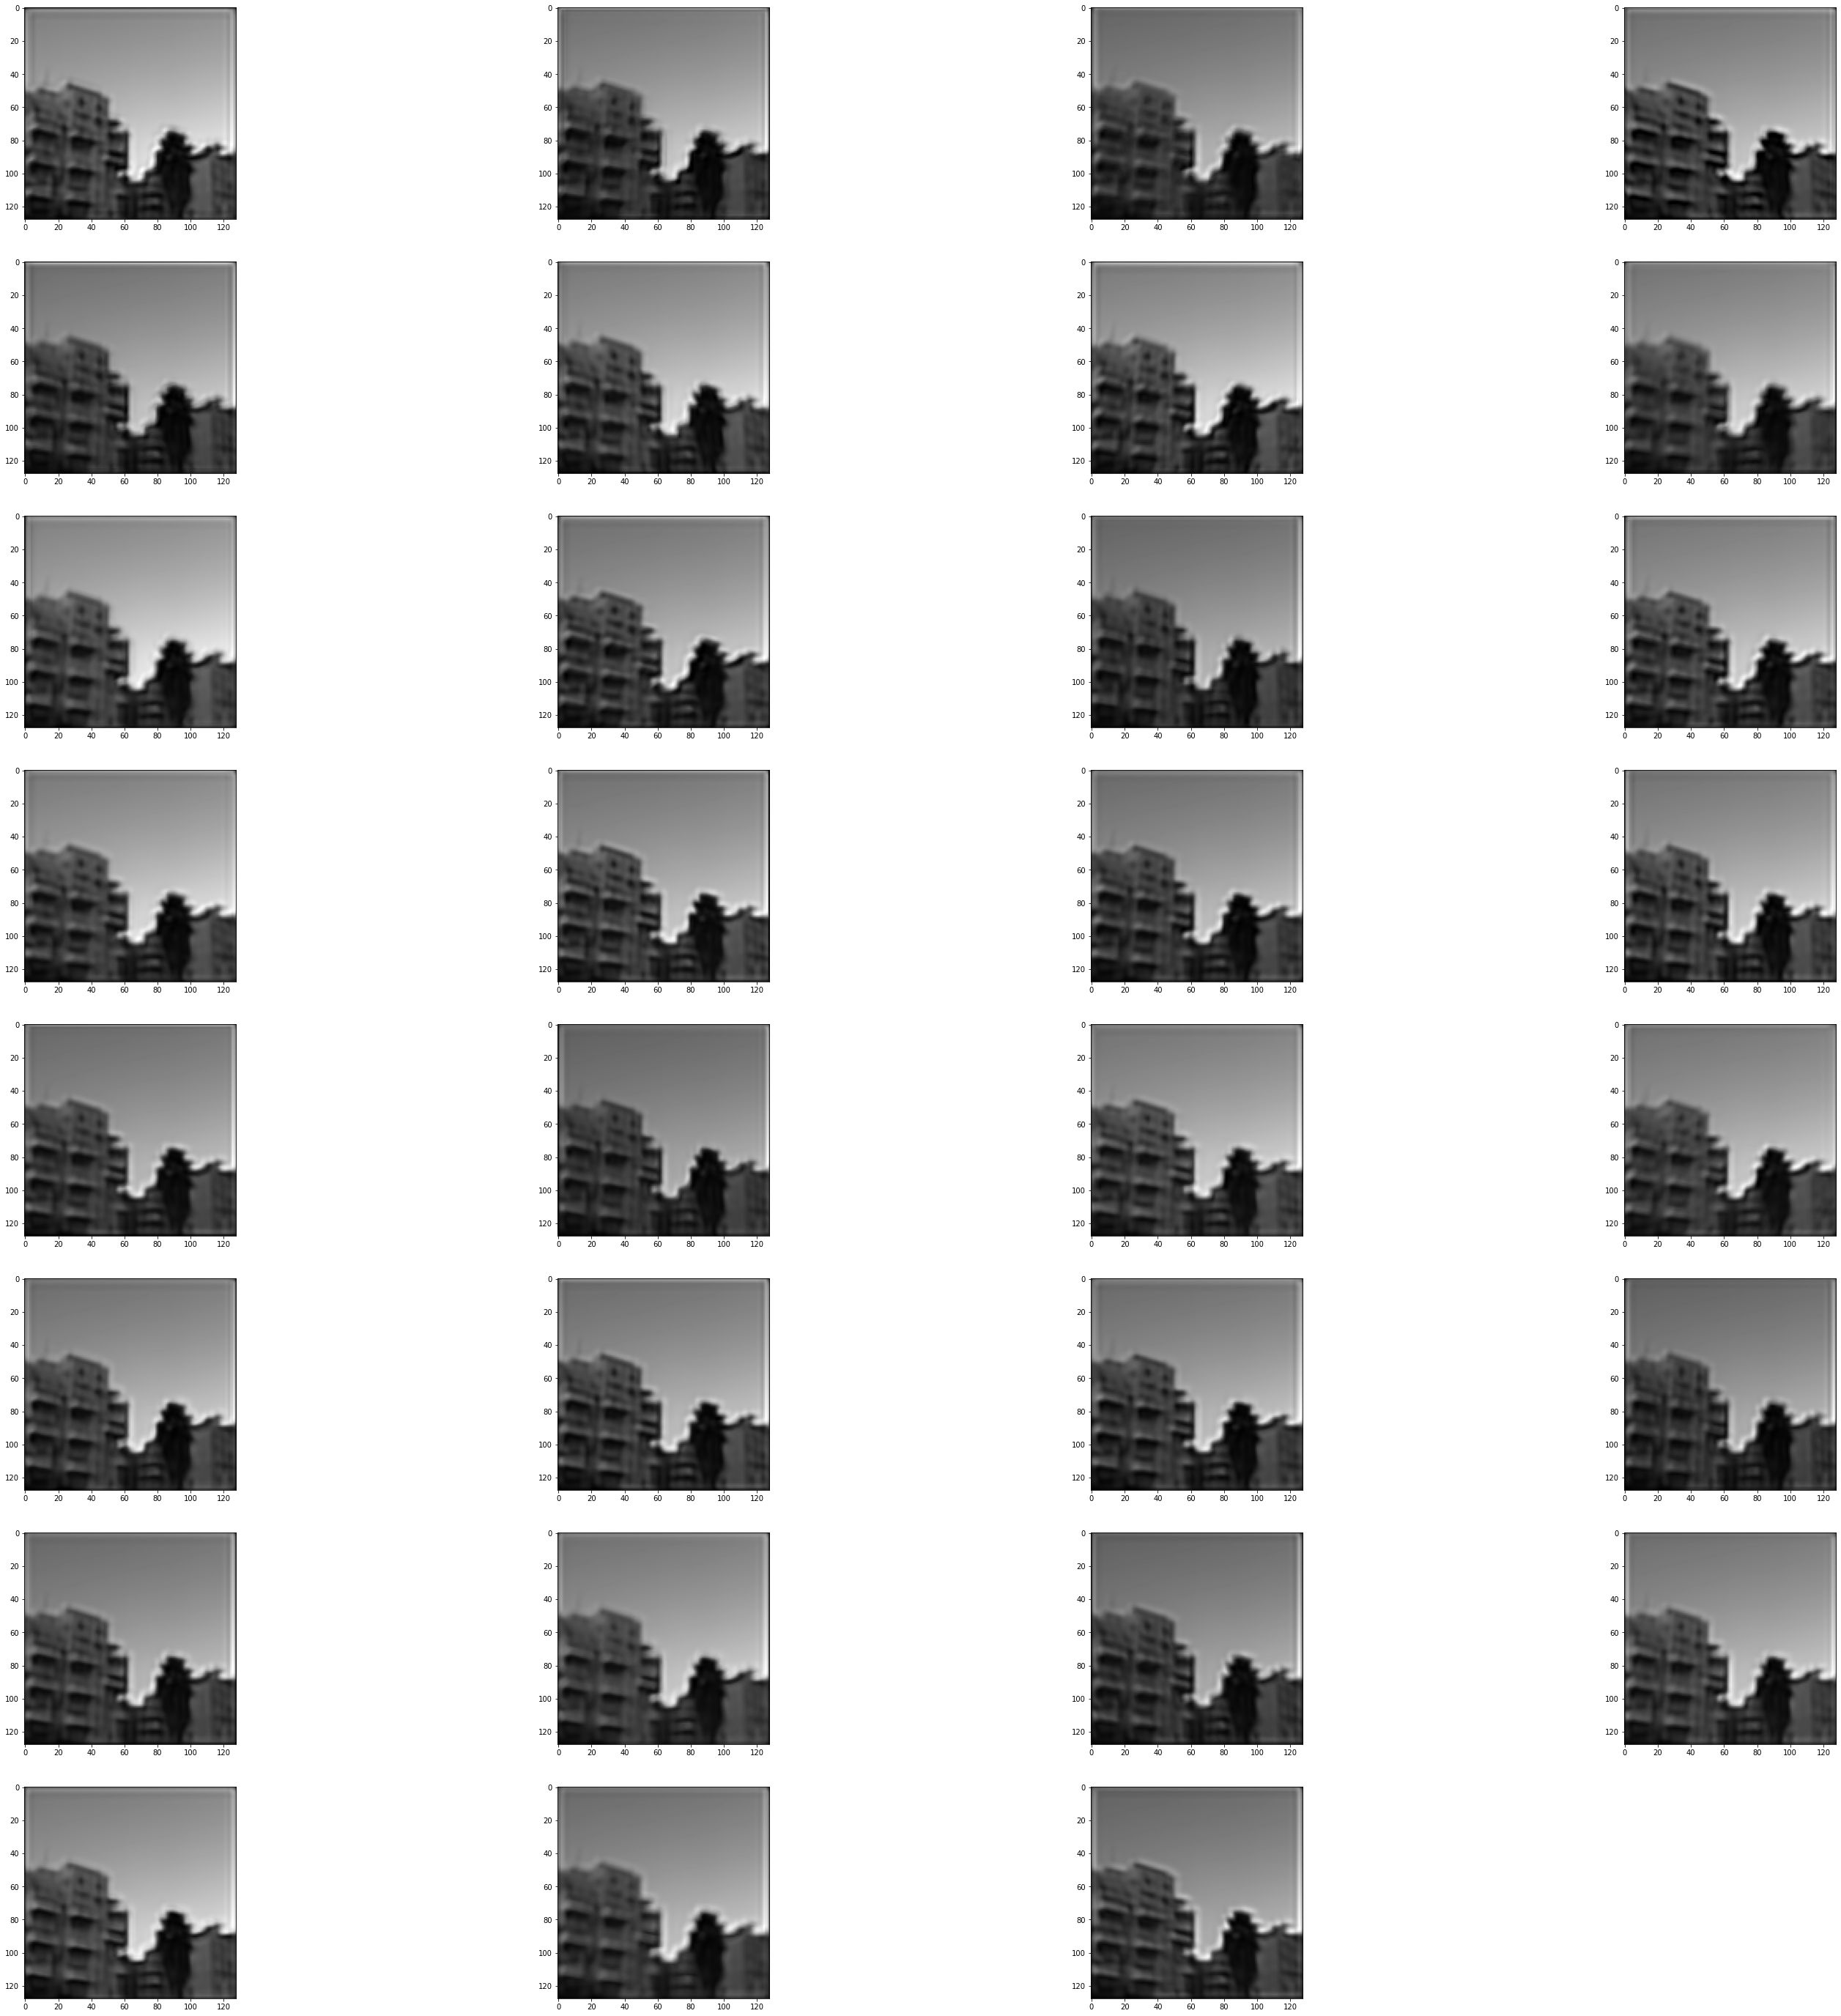

In [24]:
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(y_pred[0,:,:,i],cmap='gray')

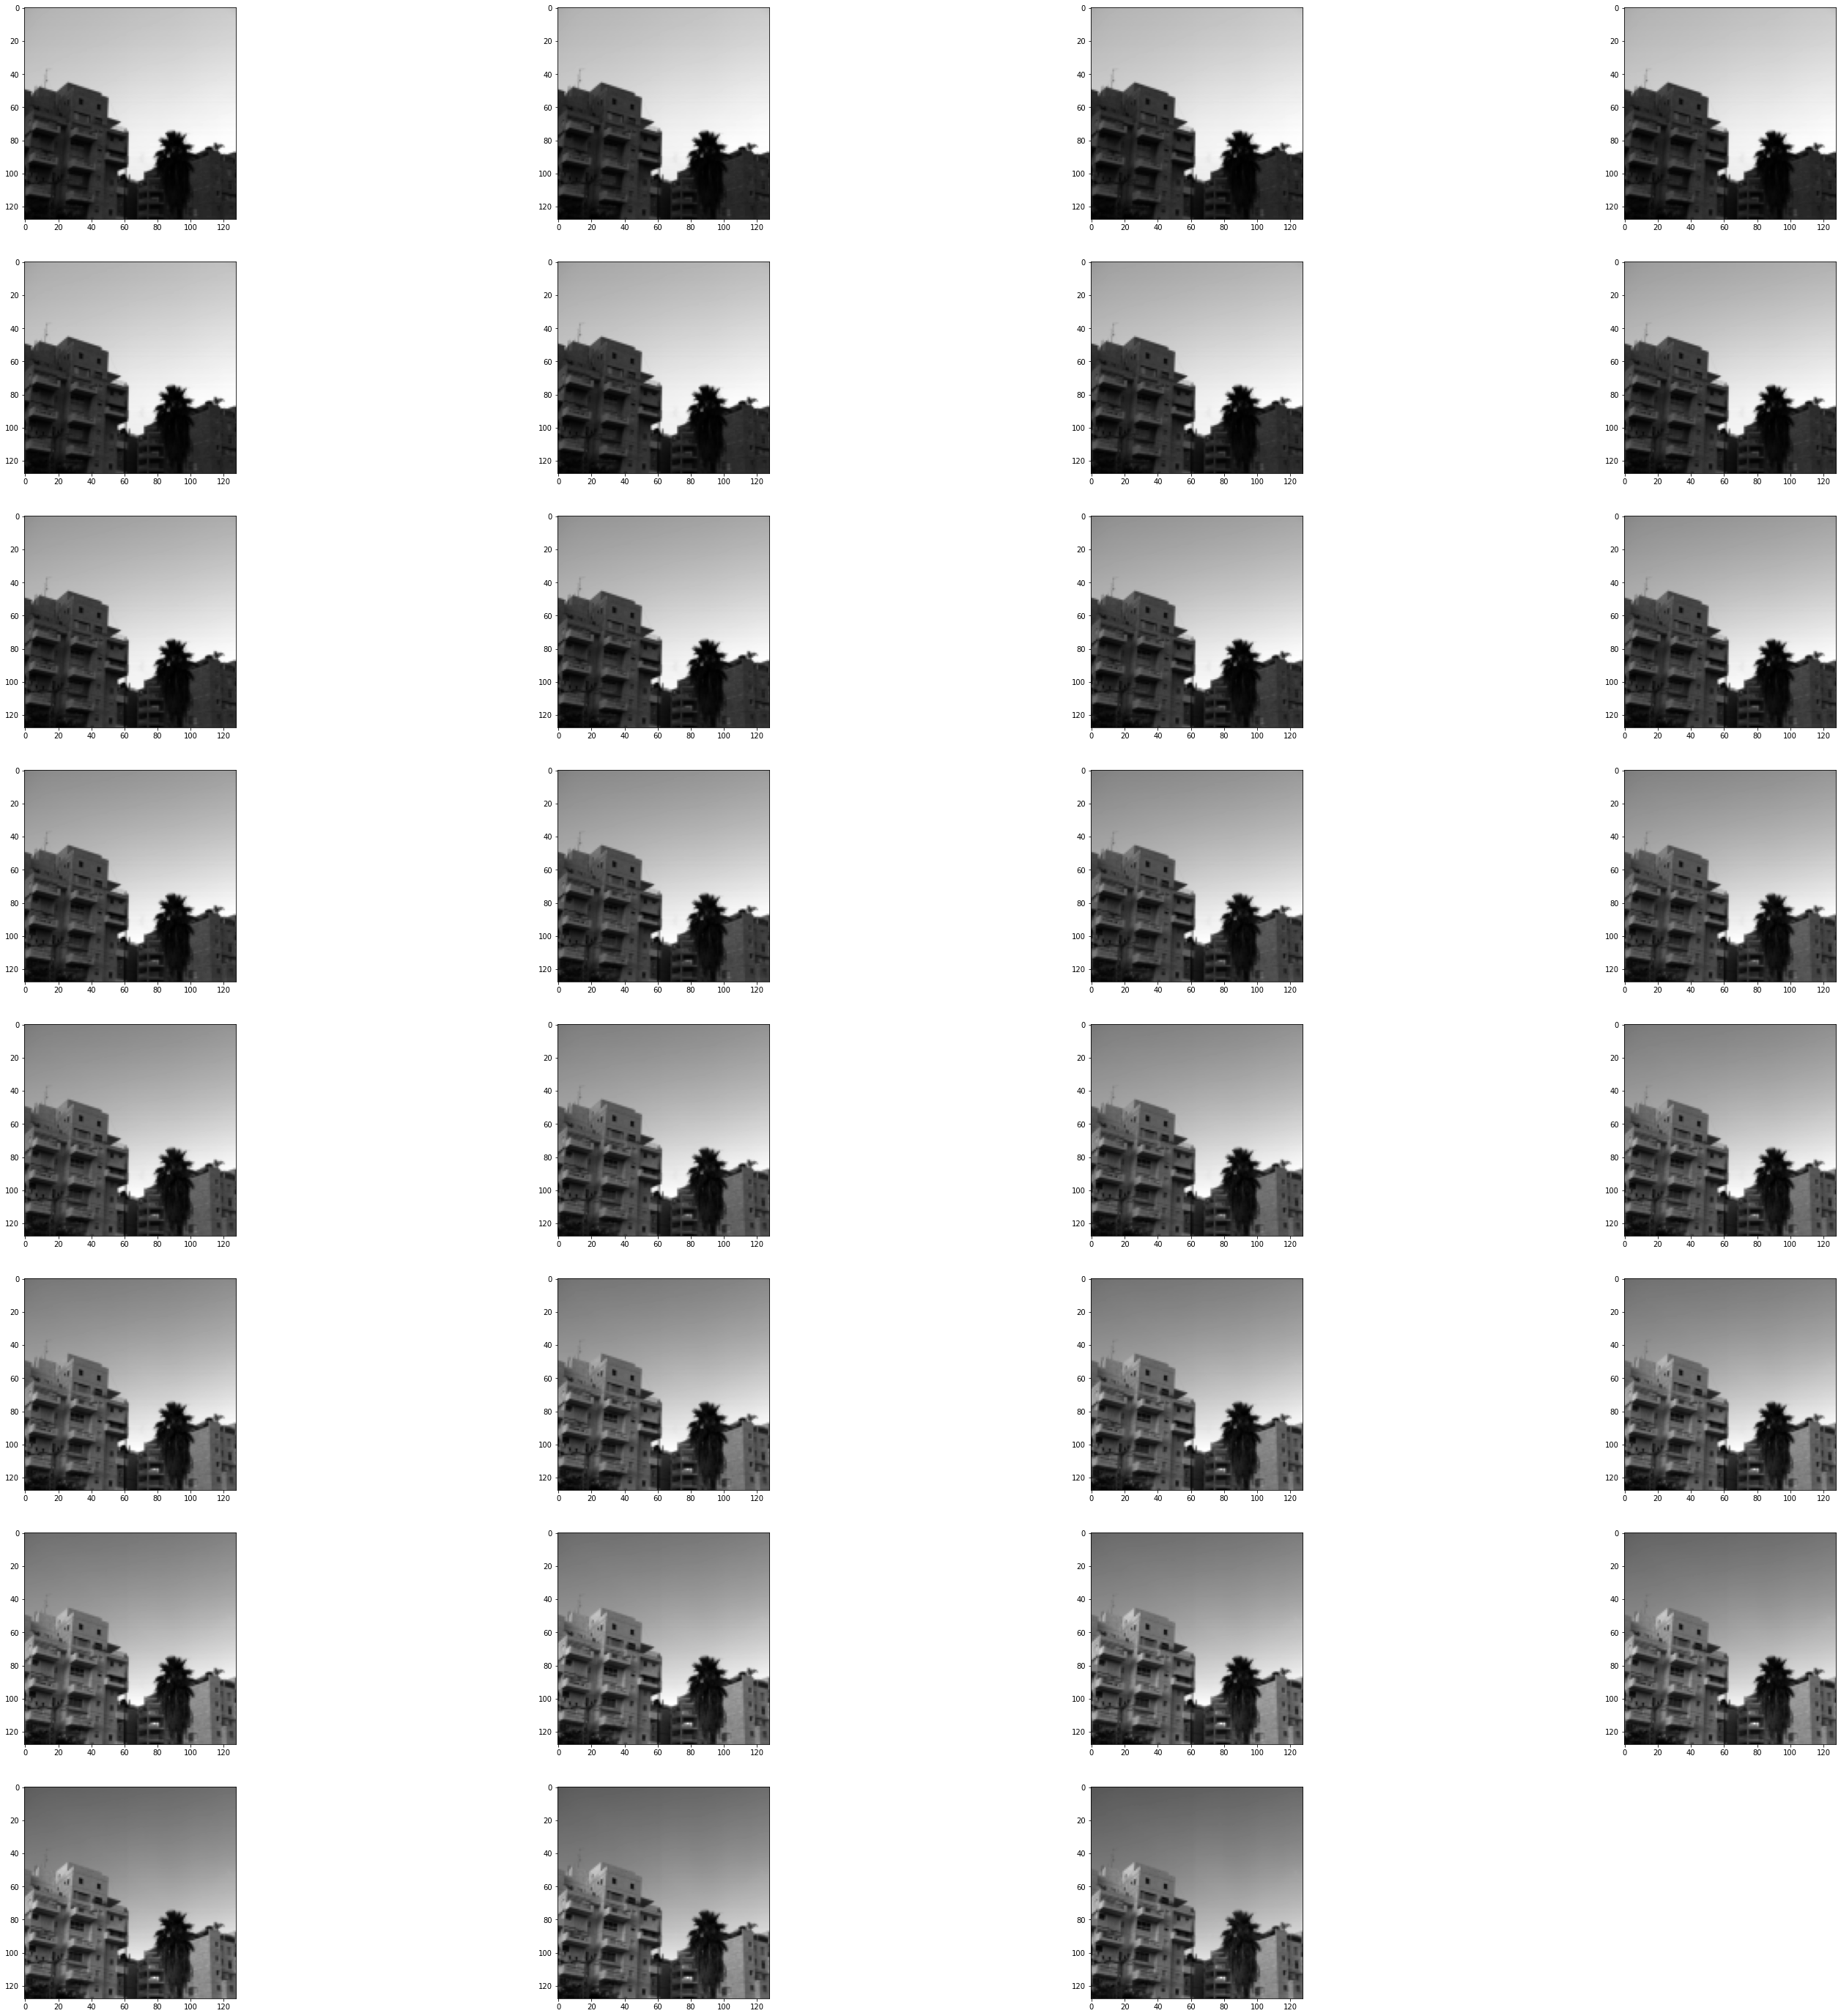

In [23]:
import matplotlib.pyplot as plt

g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(sample_y[:,:,i],cmap='gray')